## Lesson preamble

### Lecture objectives

- Learn about tidy data.
- Transform data from the long to wide format.
- Reproduce existing figures from raw data.
- Understand which raw data is underlying a figure.
- Understand which types of figures are suitable to create from raw data.

### Lecture outline

- Reshaping with gather and spread (25 min)
- Exporting data (15 min)

<!-- TODO
- Reproducing figures (50 min)
- Explore scientific questions using dplyr and ggplot.
-->


In [2]:
import pandas as pd

surveys = pd.read_csv('./surveys.csv')
surveys.head()

,record_id,month,day,year,plot_id,species_id,sex,hindfoot_length,weight,genus,species,taxa,plot_type
0,1,7,16,1977,2,NL,M,32.0,NaN,Neotoma,albigula,Rodent,Control
1,72,8,19,1977,2,NL,M,31.0,NaN,Neotoma,albigula,Rodent,Control
2,224,9,13,1977,2,NL,NaN,NaN,NaN,Neotoma,albigula,Rodent,Control
3,266,10,16,1977,2,NL,NaN,NaN,NaN,Neotoma,albigula,Rodent,Control
4,349,11,12,1977,2,NL,NaN,NaN,NaN,Neotoma,albigula,Rodent,Control


<!-- TODO I should talk about this during the data organization chapter also, maybe I can go into details, and this can be more like repetition? I shold mentioned splittign varibles. and to minimize storage space. -->

## Reshaping data between long and wide formats

Data is often presented in a so-called wide format, e.g. with one column per measurement:

|person|weight|height|age|
|------|------|------|---|
|A|70|170|32|
|B|85|179|28|

This can be a great way to display data so that it is easily interpretable by humans and is often used for summary statistics (commonly referred to as pivot tables). However, many data analysis functions in `pandas`, `seaborn` and other packages are optimized to work with the tidy data format. Tidy data is a long format where each row is a single observation and each column contains a single variable:

|person|measure|value|
|------|-----------|-----|
|     A|     weight|   70|
|     A|     height|  170|
|     A|        age|   32|
|     B|     weight|   85|
|     B|     height|  179|
|     B|        age|   28|

`pandas` enables a wide range of manipulations of the structure of data, including alternating between the long and wide format. The survey data presented here is in a tidy format. To facilitate visual comparisons of the relationships between measurements across variables, it would be beneficial to display this data in the wide format. For example, what is the relationship between mean weights of different species caught at the same plot type?

### Subset data

To make facilitate the visualization of the the transformations between wide and tidy data,  it is beneficial to create a subset of the data.

In [3]:
species_sub = ['albigula', 'flavus', 'merriami']
plot_id_sub = list(range(5, 11))
cols = ['record_id', 'species', 'weight', 'plot_type']
surveys_sub = surveys.loc[(surveys['plot_id'].isin(plot_id_sub)) & (surveys['species'].isin(species_sub)), cols]
surveys_sub.head(10)

,record_id,species,weight,plot_type
17415,465,albigula,NaN,Rodent Exclosure
17416,875,albigula,212.0,Rodent Exclosure
17417,2346,albigula,239.0,Rodent Exclosure
17418,3032,albigula,135.0,Rodent Exclosure
17419,4837,albigula,185.0,Rodent Exclosure
17420,5024,albigula,186.0,Rodent Exclosure
17421,5161,albigula,193.0,Rodent Exclosure
17422,5276,albigula,194.0,Rodent Exclosure
17423,5400,albigula,248.0,Rodent Exclosure
17424,5458,albigula,235.0,Rodent Exclosure


In [4]:
surveys_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2568 entries, 17415 to 34083
Data columns (total 4 columns):
record_id    2568 non-null int64
species      2568 non-null object
weight       2497 non-null float64
plot_type    2568 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 100.3+ KB


### Long to wide with `pivot()` and `pivot_table()`

A long to wide transformation would be suitable to effectively visualize the relationship between the mean body weights of each species within the different plot types used to trap the animals. The first step in creating this table is to compute the mean weight for each species in each plot type.

In [36]:
surveys_sub_gsp = (
    surveys_sub
        .groupby(['species', 'plot_type'])['weight']
        .mean()
        .reset_index()
)
surveys_sub_gsp

,species,plot_type,weight
0,albigula,Control,133.857143
1,albigula,Rodent Exclosure,185.342105
2,albigula,Short-term Krat Exclosure,179.933333
3,albigula,Spectab exclosure,161.818182
4,flavus,Control,7.056604
5,flavus,Rodent Exclosure,8.121951
6,flavus,Short-term Krat Exclosure,7.809524
7,flavus,Spectab exclosure,7.371429
8,merriami,Control,43.405405
9,merriami,Rodent Exclosure,42.964989


To remove the repeating information for 'species' and 'plot_type', this table can be pivoted into a wide formatted using the `pivot()` method. The arguments passed to `pivot()` includes the rows (the index), the columns, and which values should populate the table. 

In [6]:
surveys_sub_gsp.pivot(index='plot_type', columns='species', values='weight')

species,albigula,flavus,merriami
plot_type,,,
Control,133.857143,7.056604,43.405405
Rodent Exclosure,185.342105,8.121951,42.964989
Short-term Krat Exclosure,179.933333,7.809524,42.097674
Spectab exclosure,161.818182,7.371429,43.223270


Compare how this table is displayed with the table in the previous cell. It is certainly easier to spot differences between the species and plot types in this wide format.

Since presenting summary statistics in a wide format is such a common operation, `pandas` has a dedicated method, `pivot_table()`, that performs both the data aggregation pivoting.

In [7]:
surveys_sub.pivot_table(index='plot_type', columns='species', values='weight')

species,albigula,flavus,merriami
plot_type,,,
Control,133.857143,7.056604,43.405405
Rodent Exclosure,185.342105,8.121951,42.964989
Short-term Krat Exclosure,179.933333,7.809524,42.097674
Spectab exclosure,161.818182,7.371429,43.223270


Although `pivot_table()` is the most convenient way to aggregate *and* pivot data, `pivot()` is still useful to reshape a data frame from wide to long *without* performing aggregation.

With the data in a wide format, the pairwise correlations between the columns can be computed using `corr()`.

In [28]:
surveys_sub_pvt = surveys_sub.pivot_table(index='plot_type', columns='species', values='weight')
surveys_sub_pvt.corr()

species,albigula,flavus,merriami
species,,,
albigula,1.000000,0.958991,-0.680736
flavus,0.958991,1.000000,-0.589786
merriami,-0.680736,-0.589786,1.000000


The columns and rows can be swapped in the call to `pivot_table()`. This is useful both to present the table differently and to perform computations on a different axis (dimension) of the data frame (this result can also be obtained by calling the `transpose()` method of `subveys_sub`).

In [29]:
surveys_sub.pivot_table(index='species', columns='plot_type', values='weight')

plot_type,Control,Rodent Exclosure,Short-term Krat Exclosure,Spectab exclosure
species,,,,
albigula,133.857143,185.342105,179.933333,161.818182
flavus,7.056604,8.121951,7.809524,7.371429
merriami,43.405405,42.964989,42.097674,43.223270


With `pivot_table()` it is also possible to add the values for all rows and columns, and to change the aggregation function.

In [30]:
surveys_sub.pivot_table(index='plot_type', columns='species', values='weight', margins=True, aggfunc='median')

species,albigula,flavus,merriami,All
plot_type,,,,
Control,134.0,7.0,44.0,44.0
Rodent Exclosure,185.5,8.0,44.0,44.0
Short-term Krat Exclosure,178.0,8.0,43.0,40.0
Spectab exclosure,154.0,7.0,44.0,44.0
All,176.5,7.0,44.0,43.0


### Wide to long with `melt()`

It is also a common operation to reshape data from the wide to the long format, e.g. when getting the data into the most suitable format for analysis. For this transformation, the `melt()` method can be used to sweep up a set of columns into one key-value pair.

To prepare the data frame, the `plot_type` index name can be moved to a column name with the `reset_index()` method.

In [31]:
surveys_sub_pvt

species,albigula,flavus,merriami
plot_type,,,
Control,133.857143,7.056604,43.405405
Rodent Exclosure,185.342105,8.121951,42.964989
Short-term Krat Exclosure,179.933333,7.809524,42.097674
Spectab exclosure,161.818182,7.371429,43.223270


In [32]:
surveys_sub_pvt = surveys_sub_pvt.reset_index()
surveys_sub_pvt

species,plot_type,albigula,flavus,merriami
0,Control,133.857143,7.056604,43.405405
1,Rodent Exclosure,185.342105,8.121951,42.964989
2,Short-term Krat Exclosure,179.933333,7.809524,42.097674
3,Spectab exclosure,161.818182,7.371429,43.223270


At a minimum, `melt()` only requires the name of the column that should be kept intact. All remaining columns will have their values in the `value` column and their name in the `variable` column (here, our columns already has a name "species", so this will be used automatically instead of "variable").

In [33]:
surveys_sub_pvt.melt(id_vars='plot_type')

,plot_type,species,value
0,Control,albigula,133.857143
1,Rodent Exclosure,albigula,185.342105
2,Short-term Krat Exclosure,albigula,179.933333
3,Spectab exclosure,albigula,161.818182
4,Control,flavus,7.056604
5,Rodent Exclosure,flavus,8.121951
6,Short-term Krat Exclosure,flavus,7.809524
7,Spectab exclosure,flavus,7.371429
8,Control,merriami,43.405405
9,Rodent Exclosure,merriami,42.964989


To be more explicit, all the arguments to `melt()` can be specified. This way it is also possible to exclude some columns, e.g. the species 'merriami'.

In [34]:
surveys_sub_pvt.melt(id_vars='plot_type', value_vars=['albigula', 'flavus'], 
                     var_name='species', value_name='weight')

,plot_type,species,weight
0,Control,albigula,133.857143
1,Rodent Exclosure,albigula,185.342105
2,Short-term Krat Exclosure,albigula,179.933333
3,Spectab exclosure,albigula,161.818182
4,Control,flavus,7.056604
5,Rodent Exclosure,flavus,8.121951
6,Short-term Krat Exclosure,flavus,7.809524
7,Spectab exclosure,flavus,7.371429


#### Challenge

1. Make a wide data frame with `year` as columns, `plot_id` as rows, and the
values are the number of genera per plot. You will need to summarize before
reshaping, and use the function `n_distinct` to get the number of unique
types of a genus. It's a powerful function! See `?n_distinct` for more.

2. Now take that data frame, and make it long again, so each row is a unique
`plot_id` - `year` combination.

3. The `surveys` data set is not truly wide or long because there are
two columns of measurement - `hindfoot_length` and `weight`.  This makes it
difficult to do things like look at the relationship between mean values of
each measurement per year in different plot types. Let's walk through a
common solution for this type of problem. First, use `gather` to create a
truly long dataset where we have a key column called `measurement` and a
`value` column that takes on the value of either `hindfoot_length` or
`weight`. Hint: You'll need to specify which columns are being gathered.

4. With this new truly long data set, calculate the average of each
`measurement` in each `year` for each different `plot_type`. Then
`spread` them into a wide data set with a column for `hindfoot_length` and
`weight`. Hint: Remember, you only need to specify the key and value
columns for `spread`.

```{r}
## Answer 1
rich_time <- surveys %>%
  group_by(plot_id, year) %>%
  summarize(n_genera = n_distinct(genus)) %>%
  spread(year, n_genera)

head(rich_time)

## Answer 2
rich_time %>%
  gather(year, n_genera, -plot_id)

## Answer 3
surveys_long <- surveys %>%
  gather(measurement, value, hindfoot_length, weight)

## Answer 4
surveys_long %>%
  group_by(year, measurement, plot_type) %>%
  summarize(mean_value = mean(value, na.rm=TRUE)) %>%
  spread(measurement, mean_value)
```

## Exporting data

Now that you have learned how to use **`dplyr`** to extract information from
or summarize your raw data, you may want to export these new datasets to share
them with your collaborators or for archival.

Similar to the `read_csv()` function used for reading CSV files into R, there is
a `write_csv()` function that generates CSV files from data frames.

Before using `write_csv()`, we are going to create a new folder,
`data-processed`, in our working directory that will store this generated
dataset. We don't want to store manipulated datasets in the same directory as
our raw data. It's good practice to keep them separate. The raw data would
ideally be put in a `data-raw` folder, which should only contain the raw,
unaltered data, and should be left alone to make sure we don't delete or modify
it from how it was when we downloaded or recorded it ourself. In contrast,
our R code will create the contents of the `data-processed` directory, so even
if the files it contains are deleted, we can always re-generate them.

Use the `getwd()` function to find out which is the current working directory.

```{r}
getwd()
```

Navigate to this directory in your file browser and create a folder called
`data-processed`.

Alternatively, you could use R to create this directory.

```{r}
dir.create("data-processed")

# To suppress the warning, we could do
dir.create("data-processed", showWarnings = FALSE)

# Another alternative would be to use a conditional expression, which only
# creates the directory *if* it does not already exist. The syntax here is
# similar to the for loop we created in the second lecture.
if (!dir.exists('data-processed')) {
    dir.create("data-processed")
}
```

We are going to prepare a cleaned up version of the data without NAs. Let's
start by removing observations for which the `species_id` is missing. Let's also
remove observations for which `weight` and the `hindfoot_length` are missing.
This dataset should also only contain observations of animals for which the sex
has been determined:

```{r}
surveys_complete <- surveys %>%
  filter(!is.na(species_id),       # remove missing species_id
         !is.na(weight),           # remove missing weight
         !is.na(hindfoot_length),  # remove missing hindfoot_length
         !is.na(sex))              # remove missing sex

# This expression is a succinct alternative to the above
surveys_complete_comcas <- surveys %>%
    filter(complete.cases(species_id, weight, hindfoot_length, sex))

# This is even briefer, but omits observations with NA in *any* column.
# There is no way to control which columns to use, but it is common to want
# to exclude all NAs, which in our case corresponds to the columns listed above.
surveys_complete_naomit <- na.omit(surveys)

# Compare the dimensions of the original and the cleaned data frame
dim(surveys)
dim(surveys_complete)
dim(surveys_complete_comcas)
dim(surveys_complete_naomit)
```

Now that our dataset is ready, we can save it as a CSV file in our `data-processed`
folder.

```{r}
write_csv(surveys_complete, path = "data-processed/surveys_complete.csv")
```



Notice that some genera have `NA` values. That's because some of those genera
don't have any record in that plot. Sometimes it is fine to leave those as
`NA`. Sometimes we want to fill them as zeros, in which case we would add the
argument `fill=0`.

```{r}
surveys_gw %>%
  spread(genus, mean_weight, fill = 0) %>%
  head
```

We can now do things like plot the weight of *Baiomys* against *Chaetodipus* or
examine their correlation.

```{r}
surveys_gw %>%
  spread(genus, mean_weight, fill = 0) %>%
  cor(use = "pairwise.complete")
```

# Combining two data frames

Short examples with pd.merge and pd.concat since these are so useful. Be explicit about that they are not object oriented.

# Visualization tips and tricks

## Choose an informative plots for categorical data

In [1]:
import seaborn as sns

iris = sns.load_dataset('iris')
iris.groupby('species').mean()

,sepal_length,sepal_width,petal_length,petal_width
species,,,,
setosa,5.006,3.428,1.462,0.246
versicolor,5.936,2.770,4.260,1.326
virginica,6.588,2.974,5.552,2.026


### Bar plots

What if we want a bar graph of Sepal Length by Species?

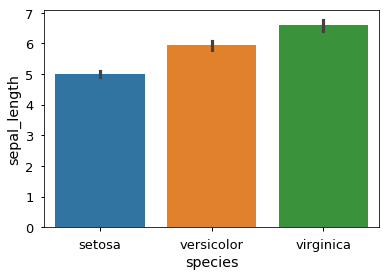

In [2]:
%matplotlib inline

sns.set_context('notebook', font_scale=1.3)
sns.barplot(x='species', y='sepal_length', data=iris)

As you can see, it is a bit cumbersome to create barplots of means with ggplot
(you need to add `stat='summary', fun.y='mean'`). The default behavior of
`geom_bar` is to count observations instead of summarize them, which actually is
a more appropriate use of a barplot for reasons that we will cover below.

### Violin plots

Text(0.5,0,'')

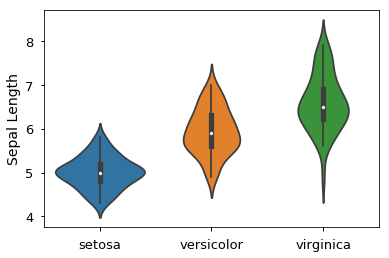

In [3]:
ax = sns.violinplot(x='species', y='sepal_length', data=iris)
ax.set_ylabel('Sepal Length', fontsize=14)
ax.set_xlabel('')
# ax.set_xticklabels(fontsize=20)

### Box plots

We can use boxplots to visualize the distribution Sepal Length within each
species:

Text(0.5,0,'')

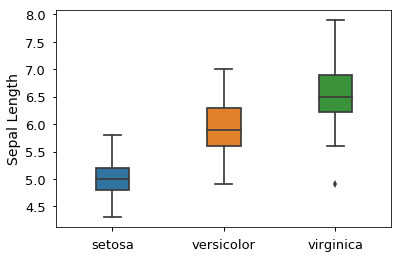

In [4]:
ax = sns.boxplot(x='species', y='sepal_length', data=iris, width=0.3)
ax.set_ylabel('Sepal Length', fontsize=14)
ax.set_xlabel('')

### Swarm plots

We can use swarmplots to visualize the distribution Sepal Length within each
species:

Text(0.5,0,'')

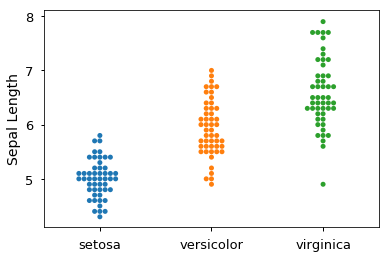

In [5]:
ax = sns.swarmplot(x='species', y='sepal_length', data=iris)
ax.set_ylabel('Sepal Length', fontsize=14)
ax.set_xlabel('')

#### Challenge

Out of the these plots, which one do you think is the most
informative and why? Which is the most true to the underlying data and how
would you know this?

### Pros and cons of different graph types

We will deepen the discussion around some of these ideas, in the context of the
following plot:

![*Reproduced with permission from [Dr. Koyama's poster*](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/TatsukiKoyama/Poster3.pdf)](./image/dynamite-bars.png)

Similar to the ideas of Tufte, it is generally advisable to avoid "decorative"
plot elements that do not convey extra information about the data, *especially*
when such elements hide the real data. For example, in the rectangles that make
up these bars, the only relevant information is given by the where the
rectangles ends on the y-axis, the rest of it is unnecessary and you could just
have used a marker (circle, square, etc) to indicate the height on the y-axis
instead. Note that the body of the rectangle is not representative for where the
data lies, there are probably no data points close to 0, and several above the
rectangle.

Barplots are especially misleading when used as data summaries, as in the
example above. In a summary plot, only two distribution parameters (a measure of
central tendency, e.g. the mean, and error, e.g. the standard deviation or a
confidence interval) are displayed, instead of showing all the individual data
points. This can be highly misleading, since different underlying distributions
can give rise to the same summary plot just as when we previously discussed that
the different distributions from the datasaurus R-package can give rise to [the
same linear regression coefficients](
https://uoftcoders.github.io/rcourse/lec11-modelling.html#challenge17).
We also have no idea of how many observations there are in each group. These
shortcomings become evident when comparing the barplot to the underlying
distributions that were used to create them:

![*Reproduced with permission from [Dr.
Koyama's poster*](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/TatsukiKoyama/Poster3.pdf)](./image/dynamite-vs-dists.png)

Immediately, you can see that conclusions drawn from the barplot, such that A
and B have the same outcome, are factually incorrect. The distribution in D is
bimodal, so representing that with a mean would be like observing black and
white birds and conclude that the average bird color is grey, it's nonsensical.
If we would have planned our follow up experiments based on the barplot alone,
we would have been setting ourselves up for failure! Always be sceptical when
you see a barplot in a published paper, and think of how the underlying
distribution might look (note that barplots are more acceptable when used to
represents counts, proportion or percentages, where there is only one data point
per group in the data set).

Boxplots and violin plots are more meaningful data summaries as they represent
more than just two distribution parameters. However, these can still be
misleading and it is often the most appropriate to show each individual
observation with a dot/hive/swarm plot, possibly combined with with a
superimposed summary plot or a marker for the mean or median *if* you think this
conveys additional information. One exception, when it is not advisable to show
all data points, is when your data set is gigantic and plotting each individual
observation would oversaturate the chart. Here, you are forced to show summary
plots or a 2D histogram.

Here is an example of how you can plot a violinplot, together with the individual
observations:

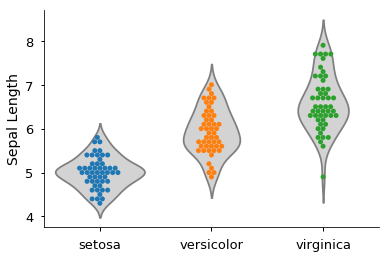

In [6]:
ax = sns.violinplot(x='species', y='sepal_length', data=iris, color='lightgrey', inner=None)
ax = sns.swarmplot(x='species', y='sepal_length', data=iris) 
ax.set_ylabel('Sepal Length', fontsize=14)
ax.set_xlabel('')
sns.despine()

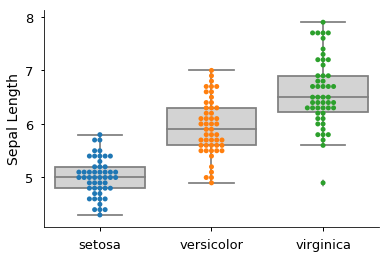

In [7]:
ax = sns.boxplot(x='species', y='sepal_length', data=iris, color='lightgrey')
ax = sns.swarmplot(x='species', y='sepal_length', data=iris) 
ax.set_ylabel('Sepal Length', fontsize=14)
ax.set_xlabel('')
sns.despine()

Notice how the boxplot layer is behind the jitter layer? What do you need to
change in the code to put the boxplot in front of the points such that it's not
hidden?

#### Challenge

So far, we've looked at the distribution of sepal length within species.  Try
making a new plot to explore the distribution of another variable within each
species.

What about making interactive graphs in R? There is a package called plotly that
lets us make our ggplot2 graphs interactive:

```{r}
library(plotly)

g <- ggplot(iris, aes(x = Species, y = Sepal.Length)) +
    geom_bar(stat='summary', fun.y='mean')
p <- ggplotly(g)
p
```

#### Challenge

Create another type of interactive graph (i.e. not a bar graph) using these
data. What kinds of graphs might interactivity add or improve the
communication and clarity of your message to?

# Changing plot appearance

## Making good graphs

### What makes a good graph?

#### Challenge

What makes a bad graph? What makes an ugly graph to you?

### Components of a graph: The data

There are many considerations to take into account when creating a graph.

Data types:

* Nominal (labels without quantitative values)
* Ordinal (the order of the values is what’s important, but the magnitude of
  difference between each value is not really known)
* Interval (interval scales are numeric scales in which we know not only the
  order, but also the exact differences between the values)
* Ratio (same properties as interval scales but with an absolute zero, e.g.
  height)

And data features:

* Scalar (simple magnitude or quantity)
* Vector (magnitude and direction)
* Tensor (vectors + other attributes)

Ask: "what kind of data/information is it?"

* What type?
* Numerical?
* Spatial?
* How many dimensions?
* Nominal/categorical?
* Narrative?

### Tufte's guidelines

* Reduce non-data ink
* Enhance the data ink

Reduces the proportion of graphic’s ink devoted to the non-redundant display of
data-information.

Avoid "chartjunk" - extraneous visual elements that detract from message.

Visual Attribute    | Non-Data | Data
--------------------|----------|-------
Line Thickness      | Thin     | Thick
Size                | Small    | Big
Brightness Contrast | Decrease | Increase
Colour Saturation   | Decrease | Increase

[More on Edward Tufte](https://www.edwardtufte.com/tufte/)

### Colour rules

* Large background colours should be quiet, muted to let brighter colors stand out
* To highlight some element of a figure, using a bright colour can be effective
* However, if brightly colouring this aspect of your figure serves no purpose,
  leave it greyscale/plain
* Here is a reference sheet with all the [colours and colour names in
  R](http://www.stat.columbia.edu/~tzheng/files/Rcolor.pdf)

### Summary

* Determine what type of data you have and how your data will be used
* Determine how many variable types are in your data
* Decide on a visual treatment for each of the variables 
* Focus on the data in your visual representation

### More general resources on plotting

* [Ten Simple Rules for Better Figures](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003833)
* [Finding the Right Color Palettes for Data Visualizations](https://blog.graphiq.com/finding-the-right-color-palettes-for-data-visualizations-fcd4e707a283)
* [Cookbook for R - Graphs](http://www.cookbook-r.com/Graphs/)
* [ggplot cheatsheet - very useful!](https://www.rstudio.com/wp-content/uploads/2015/03/ggplot2-cheatsheet.pdf)
* [Examples of bad graphs](https://www.biostat.wisc.edu/~kbroman/topten_worstgraphs/)
* [More examples of bad graphs and how to improve them](https://www.stat.auckland.ac.nz/~ihaka/120/Lectures/lecture03.pdf)
* [Wikipedia has a great article on misleading graphs](https://en.wikipedia.org/wiki/Misleading_graph)

## Matplotlib plotting and general plot customization

The knowledge of how to make an appealing and informative visualization can be put into practice by working directly with `matplotlib`, and styling different elements of the plot. This is how simplistic plotting looks in matplotlib:

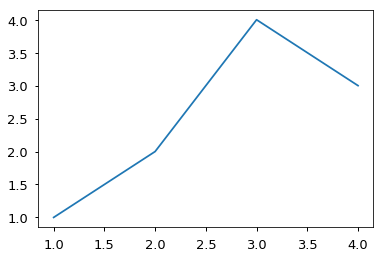

In [8]:
import matplotlib.pyplot as plt

x = [1, 2, 3, 4]
y = [1, 2, 4, 3]
plt.plot(x, y)

The default is a lineplot, to get a scatter plot use `plt.scatter`.

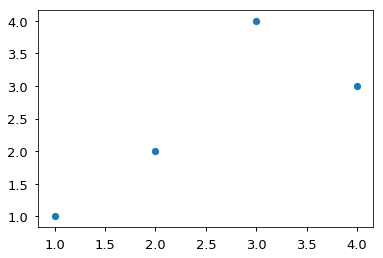

In [9]:
plt.scatter(x, y)

You can also combine the plots together.

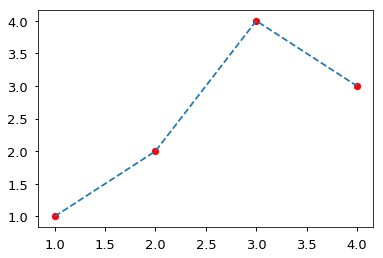

In [10]:
plt.scatter(x, y, color='red')
plt.plot(x, y, linestyle='dashed')

Often we will want to modify the plot after it is created, e.g. adding a title or label the axis. Or maybe we will want to create several subplots togheter. For all of these operations, it is easier to use the object oriented plotting interface, where you initially create the empty figure, assign the axes (subplots) to variable names and then explicitly use these axes variable names for plotting.

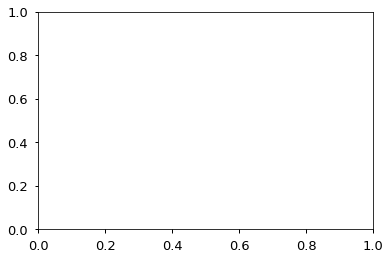

In [11]:
# An empty plot
fig, ax = plt.subplots(1, 1) # number of rows and columns

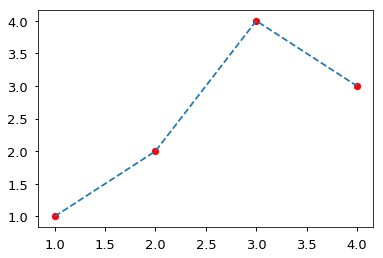

In [12]:
# Use the variable name `ax` explicitly
fig, ax = plt.subplots() # 1, 1 is the default here
ax.scatter(x, y, color='red')
ax.plot(x, y, linestyle='dashed')

Normally we don't plot data in simple lists like above, but rather we want to plot data frames (spreadsheet format data). We could simply pass the individual columns as `x` and `y`.

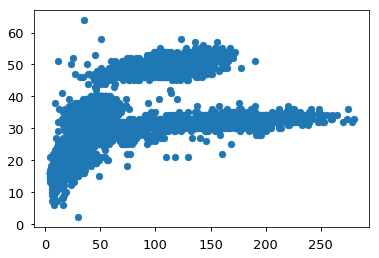

In [13]:
import pandas as pd

surveys = pd.read_csv('surveys.csv')
fig, ax = plt.subplots()
ax.scatter(surveys['weight'], surveys['hindfoot_length'])

But the plotting functions also takes a `data` argument which makes them aware of that there is a data framed passed, and then uses many of the other arguments as names of columns in the data frame.

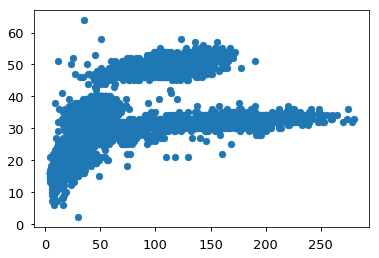

In [14]:
fig, ax = plt.subplots()
ax.scatter('weight', 'hindfoot_length', data=surveys)

With this syntax, it is easy for use to create figures consisting of several axes.

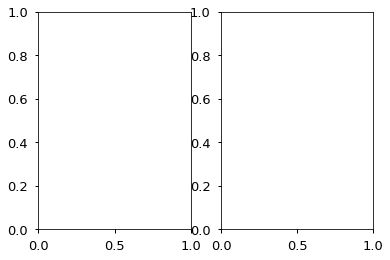

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2)

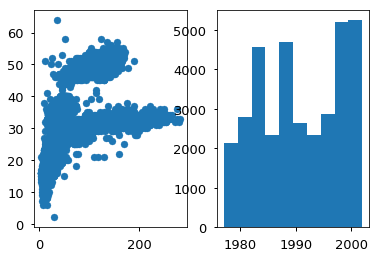

In [16]:
# teach constrained_layout or plt.tight_layout?
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter('weight', 'hindfoot_length', data=surveys)
ax2.hist('year', data=surveys); # ; supress output, histogram returns the bins

We can ensure that there are no overlapping labels in the plot by setting the layout of the figure. Let's also add a few more bins to the histogram to make it better represent the underlying data.

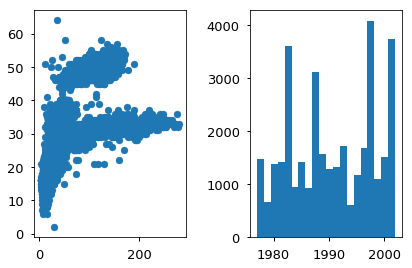

In [17]:
# teach constrained_layout or plt.tight_layout?
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter('weight', 'hindfoot_length', data=surveys)
ax2.hist('year', data=surveys, bins=20); # ; supress output, histogram returns the bins
fig.tight_layout()

Now, let's change the figure size and add a few labels like above.

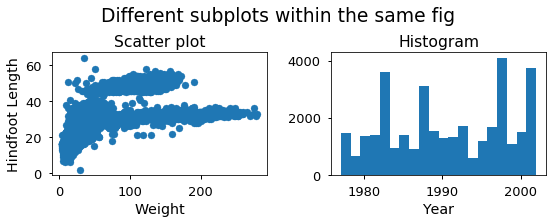

In [18]:
# teach constrained_layout or plt.tight_layout?
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.scatter('weight', 'hindfoot_length', data=surveys)
ax2.hist('year', data=surveys, bins=20); # ; supress output, histogram returns the bins

ax1.set_title('Scatter plot')
ax1.set_ylabel('Hindfoot Length')
ax1.set_xlabel('Weight')

ax2.set_title('Histogram')
ax2.set_xlabel('Year')

fig.suptitle('Different subplots within the same fig', y=1.05)
fig.tight_layout()

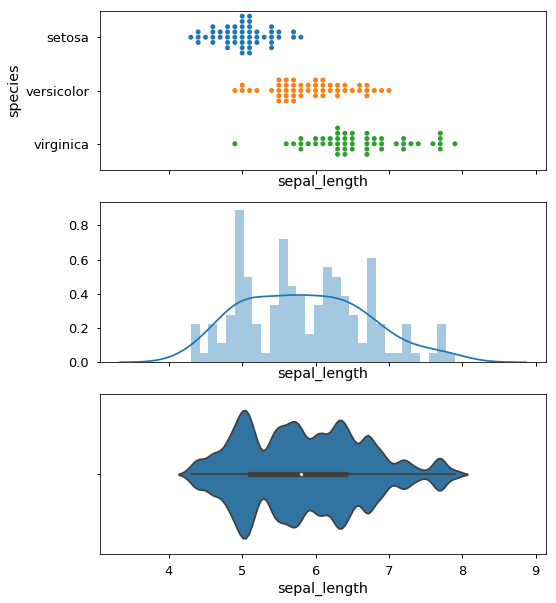

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(8, 10))

sns.swarmplot('sepal_length', 'species', data=iris, ax=ax1)
sns.distplot(iris['sepal_length'], bins=30, ax=ax2)
sns.violinplot(iris['sepal_length'], ax=ax3, bw=0.1)


In [20]:
# TODO add a few seaborn plots and show how they can be custumized with matplotlib (and also seaborn palettes)

## Avoid oversaturated plots

In [4]:
diamonds = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/ggplot2/diamonds.csv', index_col=0)
diamonds.tail()

,carat,cut,color,clarity,depth,table,price,x,y,z
53936,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53937,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53938,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74
53940,0.75,Ideal,D,SI2,62.2,55.0,2757,5.83,5.87,3.64


### Oversaturated graphs and plot choice

Last week we talked about how summary plots (especially bar plots) can sometimes
be misleading, and it is often most appropriate/ideal to show every individual
observation with a dot plot or the like, perhaps combined with summary markers
where appropriate. But, as we discussed last week, what if you have a gigantic
data set with a zillion observations? In large data sets, it is often the case
that plotting each individual observation would oversaturate the chart. 

Let's actually take a look at an oversaturated chart using one of the native
datasets, `diamonds`:

```{r}
ggplot(diamonds, aes(x = carat, y = price)) + 
  geom_point()
```

Because this is a dataset with 53940 observations and we are plotting it on two
dimensions, the resulting graph is incredibly oversaturated. Oversaturated
graphs make it *far more* difficult to glean information from the visualization.
We're going to get into a few last methods of dealing with this problem.

First, let's try making a 2D hexagonal heatmap (really a fancy histogram) with
our huge diamonds dataset. 

(It might seem like we're skipping ahead in terms of graph complexity. To learn
how to make a super simple histogram with simple count data, see
[here](http://ggplot2.tidyverse.org/reference/geom_histogram.html))

```{r}
g <- ggplot(diamonds, aes(x = carat, y = price))
g + 
  geom_hex()
```

What has this changed? Now we have a handy legend to the right of our graph
indicating the density of points across 2D space in our large dataset. We've
created our first heat map.

Wikipedia's definition of a heat map:

["A heat map (or heatmap) is a graphical representation of data where the
individual values contained in a matrix are represented as
colors."](https://en.wikipedia.org/wiki/Heat_map)

We've now added additional information to our graph and solved the saturation
problem we encountered in our first graph. If you want to change the bin size
(i.e. the size of the hexagons), you can do so as such:

```{r}
g <- ggplot(diamonds, aes(x = carat, y = price))
g + 
  geom_hex(bins = 90)
```

[Here](http://ggplot2.tidyverse.org/reference/geom_hex.html) are more resources
on hexagonal 2D heatmaps. 


[Documentation for square/rectangular heat maps of 2D bin
counts](http://ggplot2.tidyverse.org/reference/geom_bin2d.html)

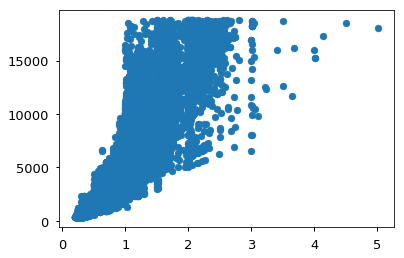

In [22]:
plt.scatter('carat', 'price', data=diamonds)

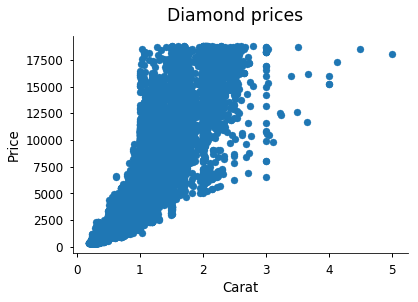

In [23]:
sns.set_context('notebook', font_scale=1.2)
# sns.set_style('white')
# sns.set(context=None, style=None, palette=None)

fig, ax = plt.subplots()
fig.suptitle('Diamond prices')
ax.scatter('carat', 'price', data=diamonds)
ax.set_xlabel('Carat')
ax.set_ylabel('Price')
sns.despine()
# Same as
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

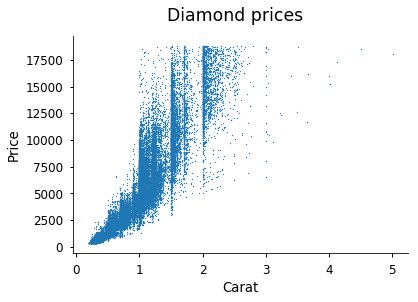

In [24]:
fig, ax = plt.subplots()

fig.suptitle('Diamond prices')

ax.scatter('carat', 'price', data=diamonds, s=1)
ax.set_xlabel('Carat')
ax.set_ylabel('Price')
sns.despine()

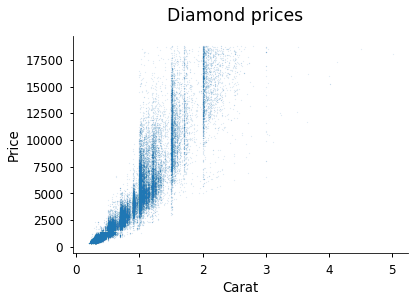

In [25]:
fig, ax = plt.subplots()

fig.suptitle('Diamond prices')
ax.scatter('carat', 'price', data=diamonds, s=1, alpha=0.1)
ax.set_xlabel('Carat')
ax.set_ylabel('Price')
sns.despine()

Make a 2D or joint histogram. Each bin is colored to display the number of data points within it.

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

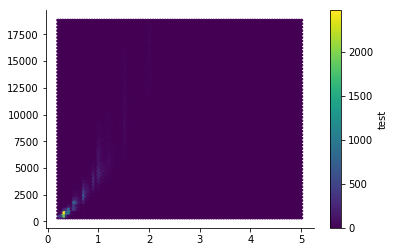

In [12]:
fig, ax = plt.subplots()
hexdata = ax.hexbin('carat', 'price', data=diamonds)
sns.despine()
cax = fig.colorbar(hexdata)

# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)
# ax.set_xlabel('Carat')
# ax.set_ylabel('Price')

There needs to be space for this colorbar. By default it will take space from the current plot/axes. Note the hexbin plot became smaller now that we added the colorbar.

Text(0,0.5,'Price')

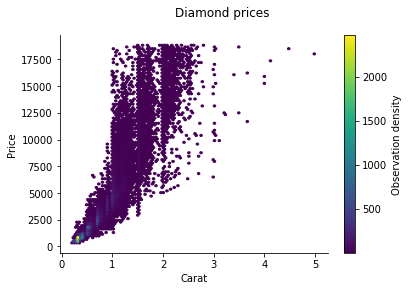

In [15]:
# also include colorbar?
fig, ax = plt.subplots()

fig.suptitle('Diamond prices')
hex_plot = ax.hexbin('carat', 'price', data=diamonds, mincnt=1)
sns.despine()
cax = fig.colorbar(hex_plot)
cax.set_label('Observation density')
ax.set_xlabel('Carat')
ax.set_ylabel('Price')
cax.set_label('Numbers')

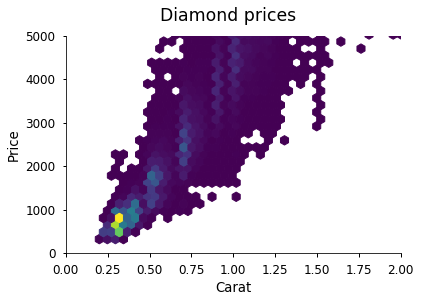

In [28]:
fig, ax = plt.subplots()

fig.suptitle('Diamond prices')
hexbin = ax.hexbin('carat', 'price', data=diamonds, mincnt=1)
ax.set_xlabel('Carat')
ax.set_ylabel('Price')
ax.set_xlim(0, 2)
ax.set_ylim(0, 5000)

sns.despine()

Text(0,0.5,'Price')

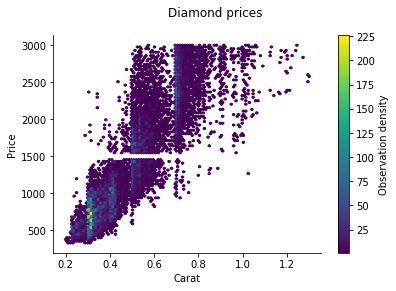

In [16]:
fig, ax = plt.subplots()

fig.suptitle('Diamond prices')
diamonds_subset = diamonds.loc[(diamonds['carat'] < 1.5) & (diamonds['price'] < 3000)]
hexbin = ax.hexbin('carat', 'price', data=diamonds_subset, mincnt=1)
sns.despine()
cax = fig.colorbar(hexbin)
cax.set_label('Observation density')
ax.set_xlabel('Carat')
ax.set_ylabel('Price')


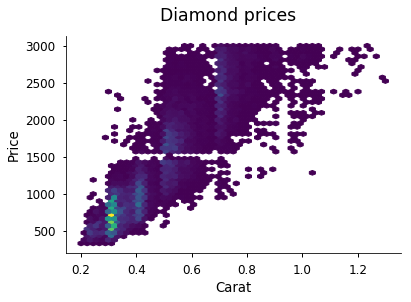

In [30]:
fig, ax = plt.subplots()

fig.suptitle('Diamond prices')
diamonds_subset = diamonds.loc[(diamonds['carat'] < 1.5) & (diamonds['price'] < 3000)]
hexbin = ax.hexbin('carat', 'price', data=diamonds_subset, mincnt=1, gridsize=50) # number of x-grids
ax.set_xlabel('Carat')
ax.set_ylabel('Price')

sns.despine()

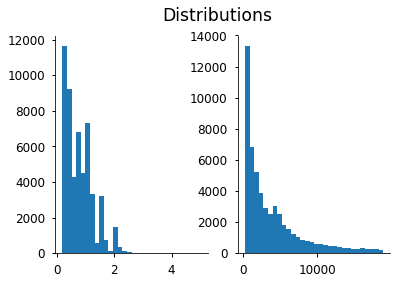

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Distributions')

ax1.hist('carat', bins=30, data=diamonds) 
ax2.hist('price', bins=30, data=diamonds) 
# ax.set_xlabel('Carat')
# ax.set_ylabel('Price')
sns.despine()

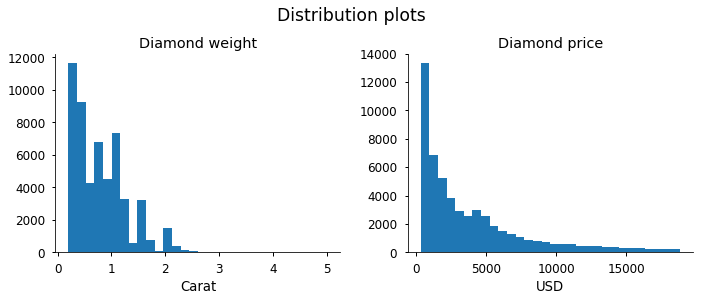

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

fig.suptitle('Distribution plots', y=1.05)

ax1.hist('carat', bins=30, data=diamonds) 
ax1.set_title('Diamond weight')
ax1.set_xlabel('Carat')

ax2.hist('price', bins=30, data=diamonds) 
ax2.set_title('Diamond price')
ax2.set_xlabel('USD')

fig.tight_layout()
sns.despine()

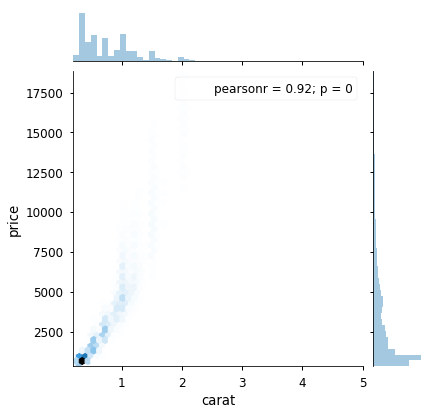

In [33]:
sns.jointplot('carat', 'price', diamonds, kind='hex')

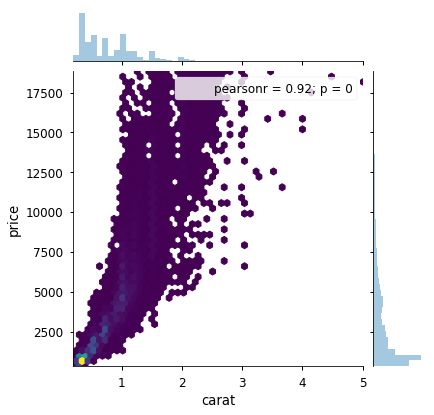

In [34]:
sns.jointplot('carat', 'price', diamonds, kind='hex', joint_kws={'cmap':'viridis', 'mincnt':1, 'gridsize':50})

## Color guidelines

### Colour rules

* Large background colours should be quiet, muted to let brighter colors stand
  out
* To highlight some element of a figure, using a bright colour can be effective
* However, if brightly colouring this aspect of your figure serves no purpose,
  leave it greyscale/plain
* Here is a reference sheet with all the [colours and colour names in
  R](http://www.stat.columbia.edu/~tzheng/files/Rcolor.pdf)

### Summary

* Determine what type of data you have and how your data will be used
* Determine how many variable types are in your data
* Decide on a visual treatment for each of the variables 
* Focus on the data in your visual representation


### Saving graphs (TODO incldue this and rewrite)

When using ggsave, R by default saves the last graph you plotted. You can also
use the GUI to export and save as an image or PDF.

```{r, eval=FALSE}
ggsave("filename.jpg")
ggsave("filename.jpg", width = 20, height = 20, units = "cm")
```

One quirk about RStudio is that if you don't specify the size of the graph,
ggsave will save the graph as the same size as it appears in your plots window.
This may or may not be what you want.

Try saving this graph:
```{r}
ggplot(iris, aes(x = Sepal.Width, y = Sepal.Length, color = Species)) + 
    geom_point()
```

## Making your graphs accessible

### Choice of colors

Colour blindness is common in the population, and red-green colour blindness in
particular affects 8% of men and 0.5% of women. Guidelines for making your
visualizations more accessible to people affected by colour blindness, will in
many cases also improve the interpretability of your graphs for people who have
standard color vision. Here are a couple of examples:

Don't use jet rainbow-coloured heatmaps. Jet colourmaps are often the default
heatmap used in many visualization packages (you've probably seen them before). 

![](./image/heatmap.png)

Colour blind viewers are going to have a difficult time distinguishing the
meaning of this heat map if some of the colours blend together.

![](./image/colourblind.png)

The jet colormap should be avoided for other reasons, including that the sharp
transitions between colors introduces visual threshold levels that do not
represent the underlying continuous data. Another issue is luminance, or
brightness. For example, your eye is drawn to the yellow and cyan regions,
because the luminance is higher. This can have the unfortunate effect of
highlighting features in your data that don't actually exist, misleading your
viewers! It also means that your graph is not going to translate well to
greyscale in publication format.

More details about jet can be found in [this blog
post](https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/) and
[this series of
posts](https://mycarta.wordpress.com/2012/05/12/the-rainbow-is-dead-long-live-the-rainbow-part-1/).
In general, when presenting continuous data, a perceptually uniform colormap is
often the most suitable choice. This type of colormap ensures that equal steps
in data are perceived as equal steps in color space. The human brain perceives
changes in lightness as changes in the data much better than, for example,
changes in hue. Therefore, colormaps which have monotonically increasing
lightness through the colormap will be better interpreted by the viewer. More
details and examples of such colormaps are available in the [matplotlib
documentation](http://matplotlib.org/users/colormaps.html), and many of the core
design principles are outlined in [this entertaining
talk](https://www.youtube.com/watch?v=xAoljeRJ3lU). Most of these colormaps are
[available in
R](http://r4ds.had.co.nz/graphics-for-communication.html#fig:brewer). 

Another approach is to use both colours and symbols. 

```{r}
ggplot(iris, aes(x = Sepal.Width, y = Sepal.Length, color = Species)) + 
  geom_point(aes(shape = factor(Species)), size = 3)
```

#### Challenge

Create any coloured figure you want and go to 
[this](http://www.color-blindness.com/coblis-color-blindness-simulator/) 
website to upload it to see how it 
looks to a colour blind person 

For more resources,
[here](http://blog.usabilla.com/how-to-design-for-color-blindness/) is a great
usability article for designing for people with colour blindness.

# =====================================================
# ======================== END ========================
# =====================================================

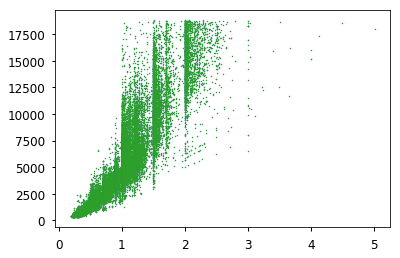

In [35]:
fig, ax = plt.subplots()
ax.scatter('carat', 'price', data=diamonds, s=1)
plt.scatter('carat', 'price', data=diamonds, s=1, alpha=0.1)
plt.scatter('carat', 'price', data=diamonds, s=1)

In [36]:
plt.hexbin

<function matplotlib.pyplot.hexbin(x, y, C=None, gridsize=100, bins=None, xscale='linear', yscale='linear', extent=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, edgecolors='face', reduce_C_function=<function mean at 0x7f6d880c9e18>, mincnt=None, marginals=False, hold=None, data=None, **kwargs)>

In [37]:
plt.hexbin()'carat', 'price', data=diamonds, mincnt=1, gridsize=80);
plt.colorbar()

SyntaxError: invalid syntax (<ipython-input-37-2790cd6c12e8>, line 1)

In [ ]:
plt.scatter('carat', 'price', data=diamonds, s=1)
plt.hexbin('weight', 'hindfoot_length', data=rodents, mincnt=1, gridsize=50);

In [ ]:
g = sns.FacetGrid(rodents)
g.map(plt.scatter, 'weight', 'hindfoot_length', s=10)


In [ ]:
{k:[plt.rcParamsDefault[k], base_context[k]] for k in sorted(base_context.keys())}

In [ ]:
       base_context = {

            "font.size": 12,
            "axes.labelsize": 11,
            "axes.titlesize": 12,
            "xtick.labelsize": 10,
            "ytick.labelsize": 10,
            "legend.fontsize": 10,

            "grid.linewidth": 1,
            "lines.linewidth": 1.75,
            "patch.linewidth": .3,
            "lines.markersize": 7,
            "lines.markeredgewidth": 0,

            "xtick.major.width": 1,
            "ytick.major.width": 1,
            "xtick.minor.width": .5,
            "ytick.minor.width": .5,

            "xtick.major.pad": 7,
"ytick.major.pad": 7,}

In [ ]:
# TODO Save these two plots for a later lecture to explain when they are not appropriate.
sns.swarmplot(x='weight', y='plot_type', data=surveys_common.sample(5000), size=2)

In [ ]:
sns.stripplot(x='weight', y='plot_type', data=surveys_common)

In [ ]:
sns.stripplot(x='weight', y='plot_type', data=surveys_common, jitter=True, size=3)

In [ ]:
# To display plots in the notebook rather than in a new window
%matplotlib inline 
surveys.plot(kind='scatter', x='weight', y='hindfoot_length')

This is one of the easiest ways of making plots and for many purposes it is perfectly fine. You can also use it to customize properties of the plot.

In [ ]:
ax = surveys.plot(kind='scatter', x='weight', y='hindfoot_length')
ax.set_title('Scatter plot', fontsize=18)
ax.set_xlabel('Weight')
ax.set_ylabel('Hindfoot length')